## <center> Data Augmentation using Variational Autoencoder (VAE)

#### Importing required packages


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import random
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
%matplotlib inline
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

import warnings
warnings.filterwarnings('ignore')

#### Following block of code controls randomness of Tensorflow and numpy.

In [2]:
import os
SEED = 1

os.environ['PYTHONHASHSEED'] =str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# keras.backend.random.set_seed(SEED)

Main Code starts here:

Importing dataset as pandas dataframe AND normalizing it using MinMax Scaler.

In [3]:
#This fucntion imports data from csv file and then returns normalized version of it.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cols_to_scale = ['A2_Pin', 'OSNR', 'BER']

def get_dataset ():
    df = pd.read_csv('Training_data_to_be_augmented_final.csv')
    print('Shape of Dataset is : ', df.shape)
    
    df.drop_duplicates(inplace = True)   #dropping duplicates if any
    
    print('Shape of Dataset after dropping duplicates is : ', df.shape)
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])  #scaling dataset using MinMax Scaler
    
    return df
    

For plotting dataset in 3D.

In [4]:
import plotly.express as px

def plot_dataset(df):
    fig = px.scatter_3d(df, x='BER', y='OSNR', z='A2_Pin', color= 'Failure_Type')
    fig.show()

Calling function to get normalize dataset.

In [5]:
dataset = get_dataset()

Shape of Dataset is :  (2186, 5)
Shape of Dataset after dropping duplicates is :  (2186, 5)


Plotting OSNR and BER only to see if data is seperable in 2D or not.

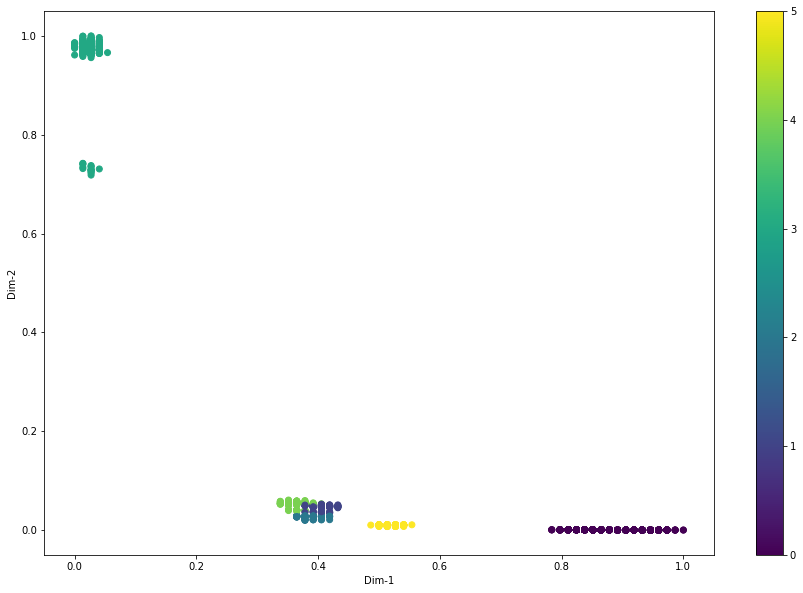

In [6]:
plt.figure(figsize=(15, 10))
plt.scatter( dataset['OSNR'],  dataset['BER'], c= dataset['Failure_Type'])
plt.xlabel('Dim-1')
plt.ylabel('Dim-2')
plt.colorbar()
plt.show()

#### Splitting data between test and train data sets

Note:

i) stratify = y ensures that split has same proportion of all the classes as in the original data set.

ii) y has labels of failure types i.e.,

- Label-0: Normal Operation (BW = 36 GHz , Attenuation = 0 dB, fc = 192.300 THz)

- Label-1: Filtering Effect (BW = 26 GHz , Attenuation = 0 dB, fc = 192.300 THz)

- Label-2: Attenuation (BW = 36 GHz , Attenuation = 6 dB, fc = 192.300 THz)

- Label-3: Attenuation + Filtering Effect (BW = 26 GHz , Attenuation = 6 dB, fc = 192.300 THz)

- Label-4: Change in fc + Filtering Effect (BW = 26 GHz , Attenuation = 0 dB, fc = 192.320 THz)

- Label-5: Change in fc (BW = 36 GHz , Attenuation = 0 dB, fc = 192.320 THz)

The labels used for failure classification will be different. Normal data won't be considered so each failure type will have a modified label i.e., current label - 1. Moreover, normal data is considered here for oversampling because usually we have more normally data than failure data, so we'll be oversampling failure data up to the level of normal data and then to create a balance between all failure classes, only best samples will be selected. For more details, see ONFM (Failure Classification notebook)

In [7]:
from sklearn.model_selection import train_test_split

X = dataset.drop(['Failure_Type', 'Alarm'] , axis = 'columns') 
y = dataset['Failure_Type']

def get_train_test_data(X,y):
    x_train , x_test, y_train, y_test = train_test_split (X, y , test_size = 0.30, random_state = SEED , stratify = y)
    print('Shape of x_train is ', x_train.shape)
    print('Shape of x_test is ', x_test.shape)
    return x_train , x_test, y_train, y_test


In [8]:
x_train , x_test, y_train, y_test = get_train_test_data(X,y)

Shape of x_train is  (1530, 3)
Shape of x_test is  (656, 3)


Checking the distribution within overall data.

In [9]:
y.value_counts()

0    1231
3     486
5     159
4     126
1     110
2      74
Name: Failure_Type, dtype: int64

### Variational AutoEncoder

#### Encoder of VAE

Following block will be used for sampling to get z (sampled/latent) space. It will be employed as a layer using Lambda.

- Sampling layer, that randomly samples mu and sigma to give z that is supposed to follow normal distribution,
thanks to epsilon that follows normal distribution. This sampling approach is commonly known as reparameterization trick.


In [10]:

def sampling(args):
  mean, logvar = args
  eps = K.random_normal([latent_dim])
  rnd_sam = mean + K.exp(logvar/2) * eps              #see, because of log we are using exp
  return rnd_sam

#### Obervation : Why log_variance?

Ans: By taking the logarithm of the variance, we force the network to have the output range of the natural numbers rather than just positive values (variances would only have positive values). This allows for smoother representations for the latent space.

Source: https://towardsdatascience.com/reparameterization-trick-126062cfd3c3#:~:text=By%20taking%20the%20logarithm%20of,representations%20for%20the%20latent%20space.

Detailed answer:
It brings stability and ease of training. by definition sigma has to be a positive real number. one way to enforce this would be to use a ReLU funtion to obtain its value, but the gradient is not well defined around zero. in addition, the standard deviation values are usually very small 1>>sigma>0. the optimization has to work with very small numbers, where the floating point arithmetic and the poorly defined gradient bring numerical instabilities.

if you use the log transform, you map the numerically unstable very small numbers in [1,0] interval to [log(1), -inf], where you have a lot more space to work with. calculating log and exp are numerically stable and easy, so you basically gain space where your optimization variable can move within.

#### Following block implements loss function for VAE which was quite different from classical Autoencoder.

Losses to minimize during training of a VAE:

i) Reconstruction loss: That tries to prevent overlapping of distributions of classes within dataset. It is usually mean squared error and it is same as in classical autoencoder.

ii) KL-Divergence loss: Comes from relative entropy between normal and gaussian distribution and its purpose is to force a normal distribution on the latent distribution. If a latent distribution does not follow a normal distribution then it results in high value of KL-loss.

Note: axis = -1 performs operation on only last dimension of a tensor.




In [11]:
def loss_func(z_mean, z_logvar):

    ## Reconstruction loss

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 10       #because reconstruction loss itself can be very small so using a scaling factor
        reconstruction_loss  = keras.metrics.binary_crossentropy(y_true, y_predict)  
        return reconstruction_loss * reconstruction_loss_factor

    ## KL-divergence loss
    
    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 * K.sum(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis= -1)   
        return kl_loss

    ## Overall loss of VAE
    
    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)
        loss = reconstruction_loss + kl_loss   ## mean can also be used
        return loss

    return vae_loss

Following block of code return a trained VAE, encoder, decoder and sampling layer all are implemented in this block.

- Validation loss will be used as a training stopping criteria! If no more change, stop the training!

In [12]:
latent_dim = 2

def get_trained_VAE(x_train, x_test):
    
    #Encoder part
    enc_input = Input(shape=(x_train.shape[1], ), name='encoder input')   #input layer
    x = Dense(4, activation ='relu')(enc_input)       #first hidden layer
#     x = LeakyReLU(alpha=0.25)(x)
#     x = BatchNormalization(momentum=0.8)(x)
#     x = Dense(5, activation ='elu')(x)
#     x = Dense(3, activation ='elu')(x)
#     x = LeakyReLU(alpha=0.3)(x)
#     x = BatchNormalization(momentum=0.8)(x)
#     x = Dropout(0.2)(x)
#     x = Dense(3)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    
    ## Mean and variance layers
    
    z_mean = Dense(latent_dim, name='z_mean')(x)   #Mean values of encoded/compressed input and it should have same dimensions as latent space (weights will be learned during training)
    z_logvar = Dense(latent_dim, name='z_logvar')(x)  #Std dev. (variance) of encoded input/compressed input and it should have same dimensions as latent space (weights will be learned during training)

    #Lambda Wraps arbitrary expressions as a Layer object, here it is sampling function.
    #Z won't be trained during training phase, only z_mu and z_sigma will be trained

    z = Lambda(sampling, output_shape=latent_dim, name='latent-space')([z_mean, z_logvar])
    
    ## Binding layers of encoder
    encoder = keras.Model(enc_input, z, name='encoder')
    print('Summary of Encoder:\n')
    encoder.summary()
    
    ## Decoder part
    
    decoder = build_generator()    #The function in following block of code returns decoder part of VAE
    print('Summary of Decoder:\n')
    decoder.summary()
    
    ### Binding encoder and decoder to form a VAE
    
    enc_output = encoder(enc_input)
    dec_output = decoder(enc_output)

    vae = keras.Model(enc_input, dec_output, name='VAE')
    print('Summary of VAE:\n')
    vae.summary()
    
    ## VAE is defined up till this point. THe next step is to train this VAE.
    
    #Hyperparameters are chosen with error and trial method (multiple trials)
    
    opt = keras.optimizers.Adam(learning_rate=0.0079 , beta_1 = 0.4)   #using adam optimizer
    
    vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))    #compiling VAE
    
    # Training autoencoder
    
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 5 , mode ='min', restore_best_weights = True)
    vae.fit(x_train, x_train , epochs = 500, batch_size = 8, validation_data=(x_test, x_test),  callbacks =[early_stopping])

    return vae, encoder, decoder

In [13]:
##Decoder and Generator

def build_generator():

  noise_shape = (latent_dim,)
  dec_input = Input(shape = noise_shape, name='decoder_input')
  y = Dense(4, activation ='relu')(dec_input)
#   y = BatchNormalization(momentum=0.8)(y)
#   y = Dense(5, activation ='elu')(y)
#   y = LeakyReLU(alpha=0.25)(y)
#   y = BatchNormalization(momentum=0.8)(y)
#   y = Dropout(0.1)(y)
#   y = Dense(4, activation ='elu')(y)
#   y = Dropout(0.2)(y)
#   y = LeakyReLU(alpha=0.3)(y)
#   y = BatchNormalization(momentum=0.8)(y)
  y = Dense(x_train.shape[1], activation= 'sigmoid')(y)  #check it later on
 
  return keras.Model(dec_input, y, name='decoder')


Calling get_trained_VAE function to get trained encoder, decoder and complete VAE.

In [14]:
vae, encoder, decoder = get_trained_VAE(x_train, x_test)

Summary of Encoder:

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder input (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            16          ['encoder input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            10          ['dense[0][0]']                  
                                                                                                  
 z_logvar (Dense)               (None, 2)            10          ['dense[0][0]']                  
                                                                       

As it can be seen that our model was not trained for all specified epochs, when osciallation/ no decrease in validation loss was observed training was stopped! To avoid overfitting!

- If we see in a broader perspective, we do not need this model to predict data for future unseen samples! We are using it for augmentation! But still it is good to not have an overfitted model!

#### After our VAE is trained, we'll manipulate (i.e., oversample) latent space i.e., output of encoder (z-space)

In [15]:
def get_sampled_latent_space(encoder, X):
    sampled_latent_space  = pd.DataFrame(encoder.predict(X))
    return sampled_latent_space

In [16]:
def plot_latent_space(sampled_latent_space , y):
    plt.figure(figsize=(15, 10))
    plt.scatter(sampled_latent_space[0], sampled_latent_space[1], c= y)
    plt.xlabel('Dim-1')
    plt.ylabel('Dim-2')
    plt.colorbar()
    plt.show()

In following two blocks of code, we'll sample latent space 10 times so that we can have 10 times more data of each class.

In [17]:
sampled_latent_space_for_multiple_iterations = get_sampled_latent_space(encoder, X).copy()
sampled_latent_space_for_multiple_iterations['Failure_Type'] = y.values

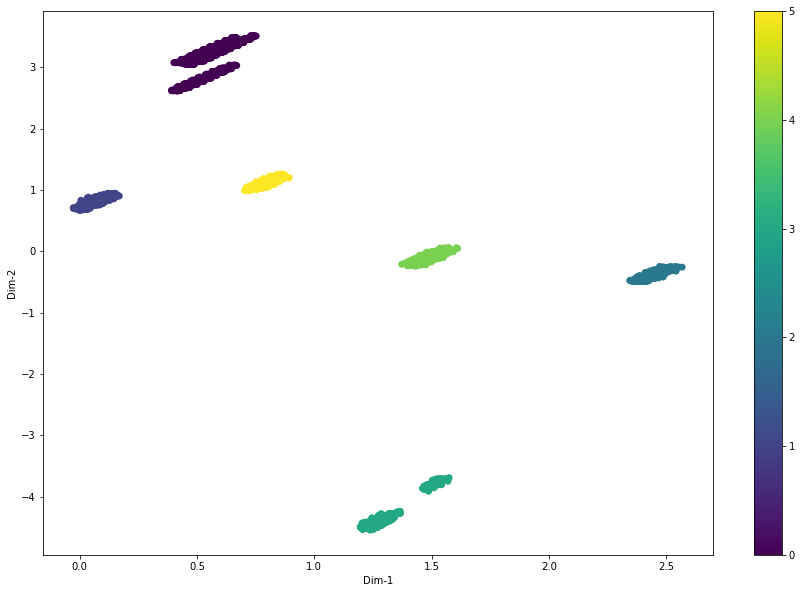

In [18]:
for i in range(9):
    sampled_latent_space = get_sampled_latent_space(encoder, X)
    sampled_latent_space['Failure_Type'] = y.values
    sampled_latent_space_for_multiple_iterations = pd.concat([sampled_latent_space_for_multiple_iterations,sampled_latent_space],  ignore_index=True)

plot_latent_space(sampled_latent_space_for_multiple_iterations, sampled_latent_space_for_multiple_iterations['Failure_Type'])

In [19]:
sampled_latent_space_for_multiple_iterations['Failure_Type'].value_counts()

0    12310
3     4860
5     1590
4     1260
1     1100
2      740
Name: Failure_Type, dtype: int64

Follwing block of code, decodes latent space and provide scaled and unscaled output of decoder i.e., our reconstructed samples.

In [20]:
def get_decoded_latent_space (latent_space, x_test):
    oversampled_latent_space_decoded  = pd.DataFrame(decoder.predict(latent_space))
    oversampled_latent_space_decoded_descaled = pd.DataFrame(scaler.inverse_transform(oversampled_latent_space_decoded))
    oversampled_latent_space_decoded_descaled.columns = x_test.columns
    oversampled_latent_space_decoded.columns = x_test.columns
    
    return oversampled_latent_space_decoded, oversampled_latent_space_decoded_descaled

In [21]:
oversampled_latent_space_decoded, oversampled_latent_space_decoded_descaled = get_decoded_latent_space (sampled_latent_space_for_multiple_iterations.drop('Failure_Type' , axis = 'columns'),x_test)

In [22]:
oversampled_latent_space_decoded.head(5)

,A2_Pin,OSNR,BER
0,0.987438,0.923637,0.000115
1,0.768368,0.397319,0.041317
2,0.955204,0.837275,0.000422
3,0.661060,0.456931,0.017127
4,0.977467,0.884095,0.000248


In [23]:
oversampled_latent_space_decoded_descaled.sample(10)

,A2_Pin,OSNR,BER
13585,-23.437082,23.483053,3.245920e-07
484,-23.408783,23.603039,2.775475e-07
6113,-23.438629,23.477442,3.268755e-07
168,-24.988161,19.600969,4.906304e-05
1892,-24.993174,19.749180,3.811069e-05
565,-30.799381,16.953817,8.944750e-04
945,-23.759970,22.664221,8.274600e-07
13966,-23.671337,22.888102,6.366301e-07
10804,-23.646925,22.986513,5.563510e-07
14345,-23.834850,22.430794,1.102581e-06


In [24]:
oversampled_latent_space_decoded_descaled.describe()

,A2_Pin,OSNR,BER
count,21860.000000,21860.000000,2.186000e+04
mean,-25.896223,21.005844,2.055574e-04
std,3.019355,2.553649,3.674641e-04
min,-30.799549,16.939388,2.201305e-07
25%,-29.577672,19.351687,5.528721e-07
50%,-23.794663,22.548999,9.543409e-07
75%,-23.628304,23.002164,5.040668e-05
max,-23.366119,23.789015,8.993302e-04


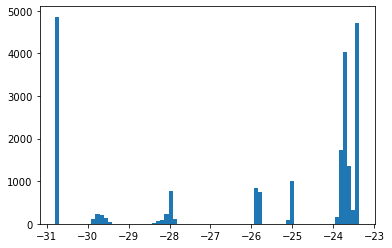

In [25]:
plt.hist(oversampled_latent_space_decoded_descaled['A2_Pin'], bins = 75)
plt.show()

Adding other features to ensure uniformity with the actual data.

In [26]:
oversampled_latent_space_decoded_descaled['Failure_Type'] = sampled_latent_space_for_multiple_iterations['Failure_Type']
oversampled_latent_space_decoded_descaled.head()

,A2_Pin,OSNR,BER,Failure_Type
0,-23.394217,23.634914,2.712458e-07,0
1,-25.037241,19.740160,3.837656e-05,1
2,-23.635969,22.995832,5.554746e-07,0
3,-25.842049,20.181292,1.600508e-05,5
4,-23.469000,23.342302,3.940071e-07,0


In [27]:
oversampled_latent_space_decoded_descaled.shape

(21860, 4)

Saving the synthetic samples, that will be used for detection and clssification of failures.

In [28]:
oversampled_latent_space_decoded_descaled_normal = oversampled_latent_space_decoded_descaled[oversampled_latent_space_decoded_descaled.Failure_Type == 0]
oversampled_latent_space_decoded_descaled_normal['Alarm'] = 0
oversampled_latent_space_decoded_descaled_failure = oversampled_latent_space_decoded_descaled[oversampled_latent_space_decoded_descaled.Failure_Type != 0]
oversampled_latent_space_decoded_descaled_failure['Alarm'] = 1

oversampled_latent_space_decoded_descaled = pd.concat([oversampled_latent_space_decoded_descaled_normal, oversampled_latent_space_decoded_descaled_failure], ignore_index=True)

In [29]:
oversampled_latent_space_decoded_descaled.to_csv('Synthetic_Data_check2.csv' , index = False)